In [ ]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx

from matplotlib.patches import FancyArrowPatch
from shapely.ops import unary_union
from scipy.spatial import cKDTree
from shapely import points as shapely_points
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["savefig.dpi"] = 300


# ============================================================
# Map decorations (keep same style)
# ============================================================
def add_north_arrow(ax, x=0.05, y=0.86, dy=0.07):
    arrow = FancyArrowPatch(
        (x, y), (x, y + dy),
        transform=ax.transAxes,
        arrowstyle="-|>",
        linewidth=1.2,
        color="black",
        zorder=30
    )
    ax.add_patch(arrow)
    ax.text(
        x, y + dy + 0.01, "N",
        transform=ax.transAxes,
        ha="center", va="bottom",
        fontsize=10, zorder=30
    )


def add_scale_bar(ax, xmin, ymin, xmax, ymax, length_km=200):
    length_m = length_km * 1000
    x0 = xmin + 0.05 * (xmax - xmin)
    y0 = ymin + 0.05 * (ymax - ymin)

    ax.plot([x0, x0 + length_m], [y0, y0],
            color="black", linewidth=4, zorder=30)

    ax.text(x0, y0 - 0.02 * (ymax - ymin), "0",
            ha="center", va="top", fontsize=9)

    ax.text(x0 + length_m, y0 - 0.02 * (ymax - ymin),
            f"{length_km} km",
            ha="center", va="top", fontsize=9)


# ============================================================
# Basemap safe wrapper (avoids SSL crash)
# ============================================================
def add_basemap_safe(ax, *, source, zoom, attribution=False):
    try:
        cx.add_basemap(ax, source=source, zoom=zoom, attribution=attribution)
        return True
    except Exception as e:
        print(f"[WARN] Basemap failed, continue without basemap. {type(e).__name__}: {e}")
        return False


# ============================================================
# IDW interpolation map function (局部范围 IDW)
# ============================================================
def plot_idw_local_map(
        *,
        excel_path: str,
        sheet_name: str,
        value_col: str,
        element_name: str,
        abu_dhabi_shp: str,
        out_png: str | None = None,
        # IDW params
        power: float = 2.0,
        k: int = 12,
        eps: float = 1e-12,
        radius: float = 5000,  # radius in meters, 控制每个点周围的影响范围
        # grid params
        grid_res: int = 1000,
        # display
        cmap: str = "RdYlGn_r",
        vmin: float | None = None,
        vmax: float | None = None,
        alpha: float = 0.85,
        # basemap (use your preferred)
        basemap=cx.providers.Esri.WorldGrayCanvas,
        basemap_zoom: int = 7,
        basemap_attribution: bool = False,
        # polygons styling (this is what makes it look like your reference)
        region_facecolor: str = "#f7f7f7",
        region_edgecolor: str = "black",
        region_linewidth: float = 0.5,
        boundary_linewidth: float = 0.5,
        # optional protected areas overlay
        protected_gpkg: str | None = None,
        protected_layer: str | None = None,
        protected_facecolor: str = "#7FD3C3",
        protected_alpha: float = 0.45,
        # extent padding
        pad_ratio: float = 0.02,
        # decorations
        scale_km: int = 200,
        cbar_label: str | None = None,
        figsize=(12, 8),
):
    # -------------------------
    # 1) boundaries -> one polygon
    # -------------------------
    regions = gpd.read_file(abu_dhabi_shp).to_crs(3857)
    abu_geom = unary_union(regions.geometry)

    protected = None
    if protected_gpkg and protected_layer:
        protected = gpd.read_file(protected_gpkg, layer=protected_layer).to_crs(3857)
        protected = protected[(~protected.geometry.isna()) & (~protected.geometry.is_empty)].copy()

    # -------------------------
    # 2) read points + clean
    # -------------------------
    df = pd.read_excel(excel_path, sheet_name=sheet_name)
    df = df[df['SurveyID']==SURVEY_ID]

    need_cols = ["Longitude", "Latitude", value_col]
    missing = [c for c in need_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in Excel: {missing}. Available: {list(df.columns)}")

    df = df.dropna(subset=need_cols).copy()
    df[value_col] = pd.to_numeric(df[value_col], errors="coerce")
    df = df.dropna(subset=[value_col]).copy()

    gdf_pts = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df["Longitude"], df["Latitude"]),
        crs="EPSG:4326"
    ).to_crs(3857)

    # keep points inside Abu Dhabi
    gdf_pts = gdf_pts[gdf_pts.geometry.within(abu_geom)].copy()

    xy = np.column_stack([gdf_pts.geometry.x.values, gdf_pts.geometry.y.values])
    vals = gdf_pts[value_col].values.astype(float)

    print(f"[INFO] {value_col} valid points (within Abu Dhabi): {xy.shape[0]}")
    if xy.shape[0] < 3:
        raise ValueError(f"Not enough valid points for IDW. Got {xy.shape[0]} points.")
    print(f"[INFO] {value_col} min={np.nanmin(vals):.4g} max={np.nanmax(vals):.4g}")

    # -------------------------
    # 3) grid
    # -------------------------
    xmin, ymin, xmax, ymax = regions.total_bounds
    xpad = pad_ratio * (xmax - xmin)
    ypad = pad_ratio * (ymax - ymin)
    xmin2, xmax2 = xmin - xpad, xmax + xpad
    ymin2, ymax2 = ymin - ypad, ymax + ypad

    xs = np.arange(xmin2, xmax2 + grid_res, grid_res)
    ys = np.arange(ymin2, ymax2 + grid_res, grid_res)
    grid_x, grid_y = np.meshgrid(xs, ys)
    grid_points = np.column_stack([grid_x.ravel(), grid_y.ravel()])

    # 4) IDW (使用所有数据点计算，并在超出半径范围的网格点赋值为 NaN)
    tree = cKDTree(xy)  # 使用所有数据点
    k_use = min(k, xy.shape[0])

    dists, idxs = tree.query(grid_points, k=k_use)
    if k_use == 1:
        dists = dists[:, None]
        idxs = idxs[:, None]

    # 计算每个网格点的权重
    weights = np.zeros_like(dists)
    weights = 1.0 / (np.power(dists, power) + eps)

    # 计算 IDW 插值值
    z = np.sum(weights * vals[idxs], axis=1) / np.sum(weights, axis=1)

    # 超出半径范围的网格点赋值为 NaN
    mask_radius = dists <= radius  # 计算网格点距离小于半径的掩码
    z[~mask_radius.any(axis=1)] = np.nan  # 对于超出半径的网格点，赋值为 NaN

    grid_z = z.reshape(grid_x.shape)  # 将插值结果按网格形状重新排列
    # -------------------------
    # 5) mask outside Abu Dhabi
    # -------------------------
    mask_points = shapely_points(grid_x.ravel(), grid_y.ravel())
    inside = np.array([abu_geom.contains(p) for p in mask_points], dtype=bool)
    mask = ~inside.reshape(grid_x.shape)
    grid_z_masked = np.ma.array(grid_z, mask=mask)

    # -------------------------
    # 6) plot (THIS is the “background style” you want)
    # -------------------------
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(xmin2, xmax2)
    ax.set_ylim(ymin2, ymax2)

    # basemap (safe)
    add_basemap_safe(ax, source=basemap, zoom=basemap_zoom, attribution=basemap_attribution)

    # IMPORTANT: cover basemap with light polygon fill (your reference look)
    regions.plot(
        ax=ax,
        facecolor=region_facecolor,
        edgecolor=region_edgecolor,
        linewidth=region_linewidth,
        zorder=4
    )
    region_label_fontsize = 11
    region_label_color = '#2b2b2b'
    region_label_weight = 'bold'
    region_keywords = [
        ("Al Dhafra", ["Dhafra"]),
        ("Abu Dhabi", ["Abu Dhabi"]),
        ("Al Ain", ["Ain"]),
    ]

    candidate_fields = ["NAMEENGLISH", "NameEnglish", "NAME", "Name", "Region", "REGION", "emirate", "EMIRATE"]
    name_field = next((f for f in candidate_fields if f in regions.columns), None)
    if name_field is None:
        raise ValueError(f"Cannot find region name field in regions. Available columns: {list(regions.columns)}")

    regions_3 = []
    for label, keys in region_keywords:
        mask = np.zeros(len(regions), dtype=bool)
        for k in keys:
            mask |= regions[name_field].astype(str).str.contains(k, case=False, na=False)
        reg = regions[mask].copy()
        if len(reg) == 0:
            print(f"[WARN] Region '{label}' not matched by keywords {keys} in field '{name_field}'")
        else:
            # dissolve to one polygon per label, then compute a safe interior point
            reg_one = reg.dissolve()  # index becomes 0/label-like; geometry is merged
            rp = reg_one.geometry.iloc[0].representative_point()  # guaranteed inside polygon
            regions_3.append((label, rp.x, rp.y))

    for label, x, y in regions_3:
        ax.text(
            x, y, label,
            ha="center", va="center",
            fontsize=region_label_fontsize,
            color=region_label_color,
            fontweight=region_label_weight,
            zorder=25,
        )

    # optional protected
    if protected is not None:
        protected.plot(
            ax=ax,
            facecolor=protected_facecolor,
            edgecolor="none",
            alpha=protected_alpha,
            zorder=4.5
        )

    # IDW raster on top
    im = ax.imshow(
        grid_z_masked,
        extent=(xs.min(), xs.max(), ys.min(), ys.max()),
        origin="lower",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        alpha=alpha,
        zorder=5
    )

    # boundary outline on top
    regions.boundary.plot(ax=ax, color="black", linewidth=boundary_linewidth, zorder=10)

    add_north_arrow(ax)
    add_scale_bar(ax, xmin2, ymin2, xmax2, ymax2, length_km=scale_km)

    cbar = fig.colorbar(im, ax=ax, fraction=0.03, pad=0.02)
    if cbar_label is None:
        cbar_label = f"{element_name} Concentration (mg/kg) - IDW"
    cbar.set_label(cbar_label, fontsize=10)

    ax.set_axis_off()

    if out_png:
        os.makedirs(os.path.dirname(out_png), exist_ok=True)
        fig.savefig(out_png, dpi=300, bbox_inches="tight")
        print("[INFO] Saved:", out_png)

    plt.show()
    return fig, ax

OUT_DIR = r"../Result_hmq/Ch07_Figures"
os.makedirs(OUT_DIR, exist_ok=True)
SURVEY_ID = 9
# Arsenic, Barium, Cadmium, Chromium_Total, Cobalt, Copper, Lead_aqua, Manganese, Nickel_aqua, Strontium, Zinc
name_dict = {
    "Arsenic": "Arsenic",
    "Antimony": "Antimony",
    "Barium": "Barium",
    "Beryllium": "Beryllium",
    "Cadmium": "Cadmium",
    "Cobalt": "Cobalt",
    "Copper": "Copper",
    "Lead": "Lead_aqua",
    "Lithium": "Lithium",
    "Manganese": "Manganese",
    "Molybdenum": "Molybdenum",
    "Nickel": "Nickel_aqua",
    "Selenium": "Selenium_aqua",
    "Strontium": "Strontium",
    "Vanadium": "Vanadium",
    "Zinc": "Zinc",
    "Mercury": "InorganicMercury",
}
for element in name_dict.keys():
    fig, ax = plot_idw_local_map(
        excel_path=r"../Result_hmq/Soil quality data QC/Soil quality data QC 2025.xlsx",
        sheet_name="Processed_Data",
        value_col=name_dict[element],
        element_name=element,
        abu_dhabi_shp=r"../data_hmq/Map/abu_dhabi.shp",
        basemap=cx.providers.Esri.WorldGrayCanvas,
        basemap_zoom=7,
        grid_res=500,
        cmap="RdYlGn_r",
        radius=10000,
    )
    fig.savefig(os.path.join(OUT_DIR, f"Ch07_{element}_IDW.png"), bbox_inches="tight", pad_inches=0.1)
    fig.savefig(os.path.join(OUT_DIR, f"Ch07_{element}_IDW.svg"), bbox_inches="tight", pad_inches=0.1)

[INFO] Arsenic valid points (within Abu Dhabi): 165
[INFO] Arsenic min=0.73 max=4.113


[INFO] satph valid points (within Abu Dhabi): 169
[INFO] satph min=6.2 max=8.5


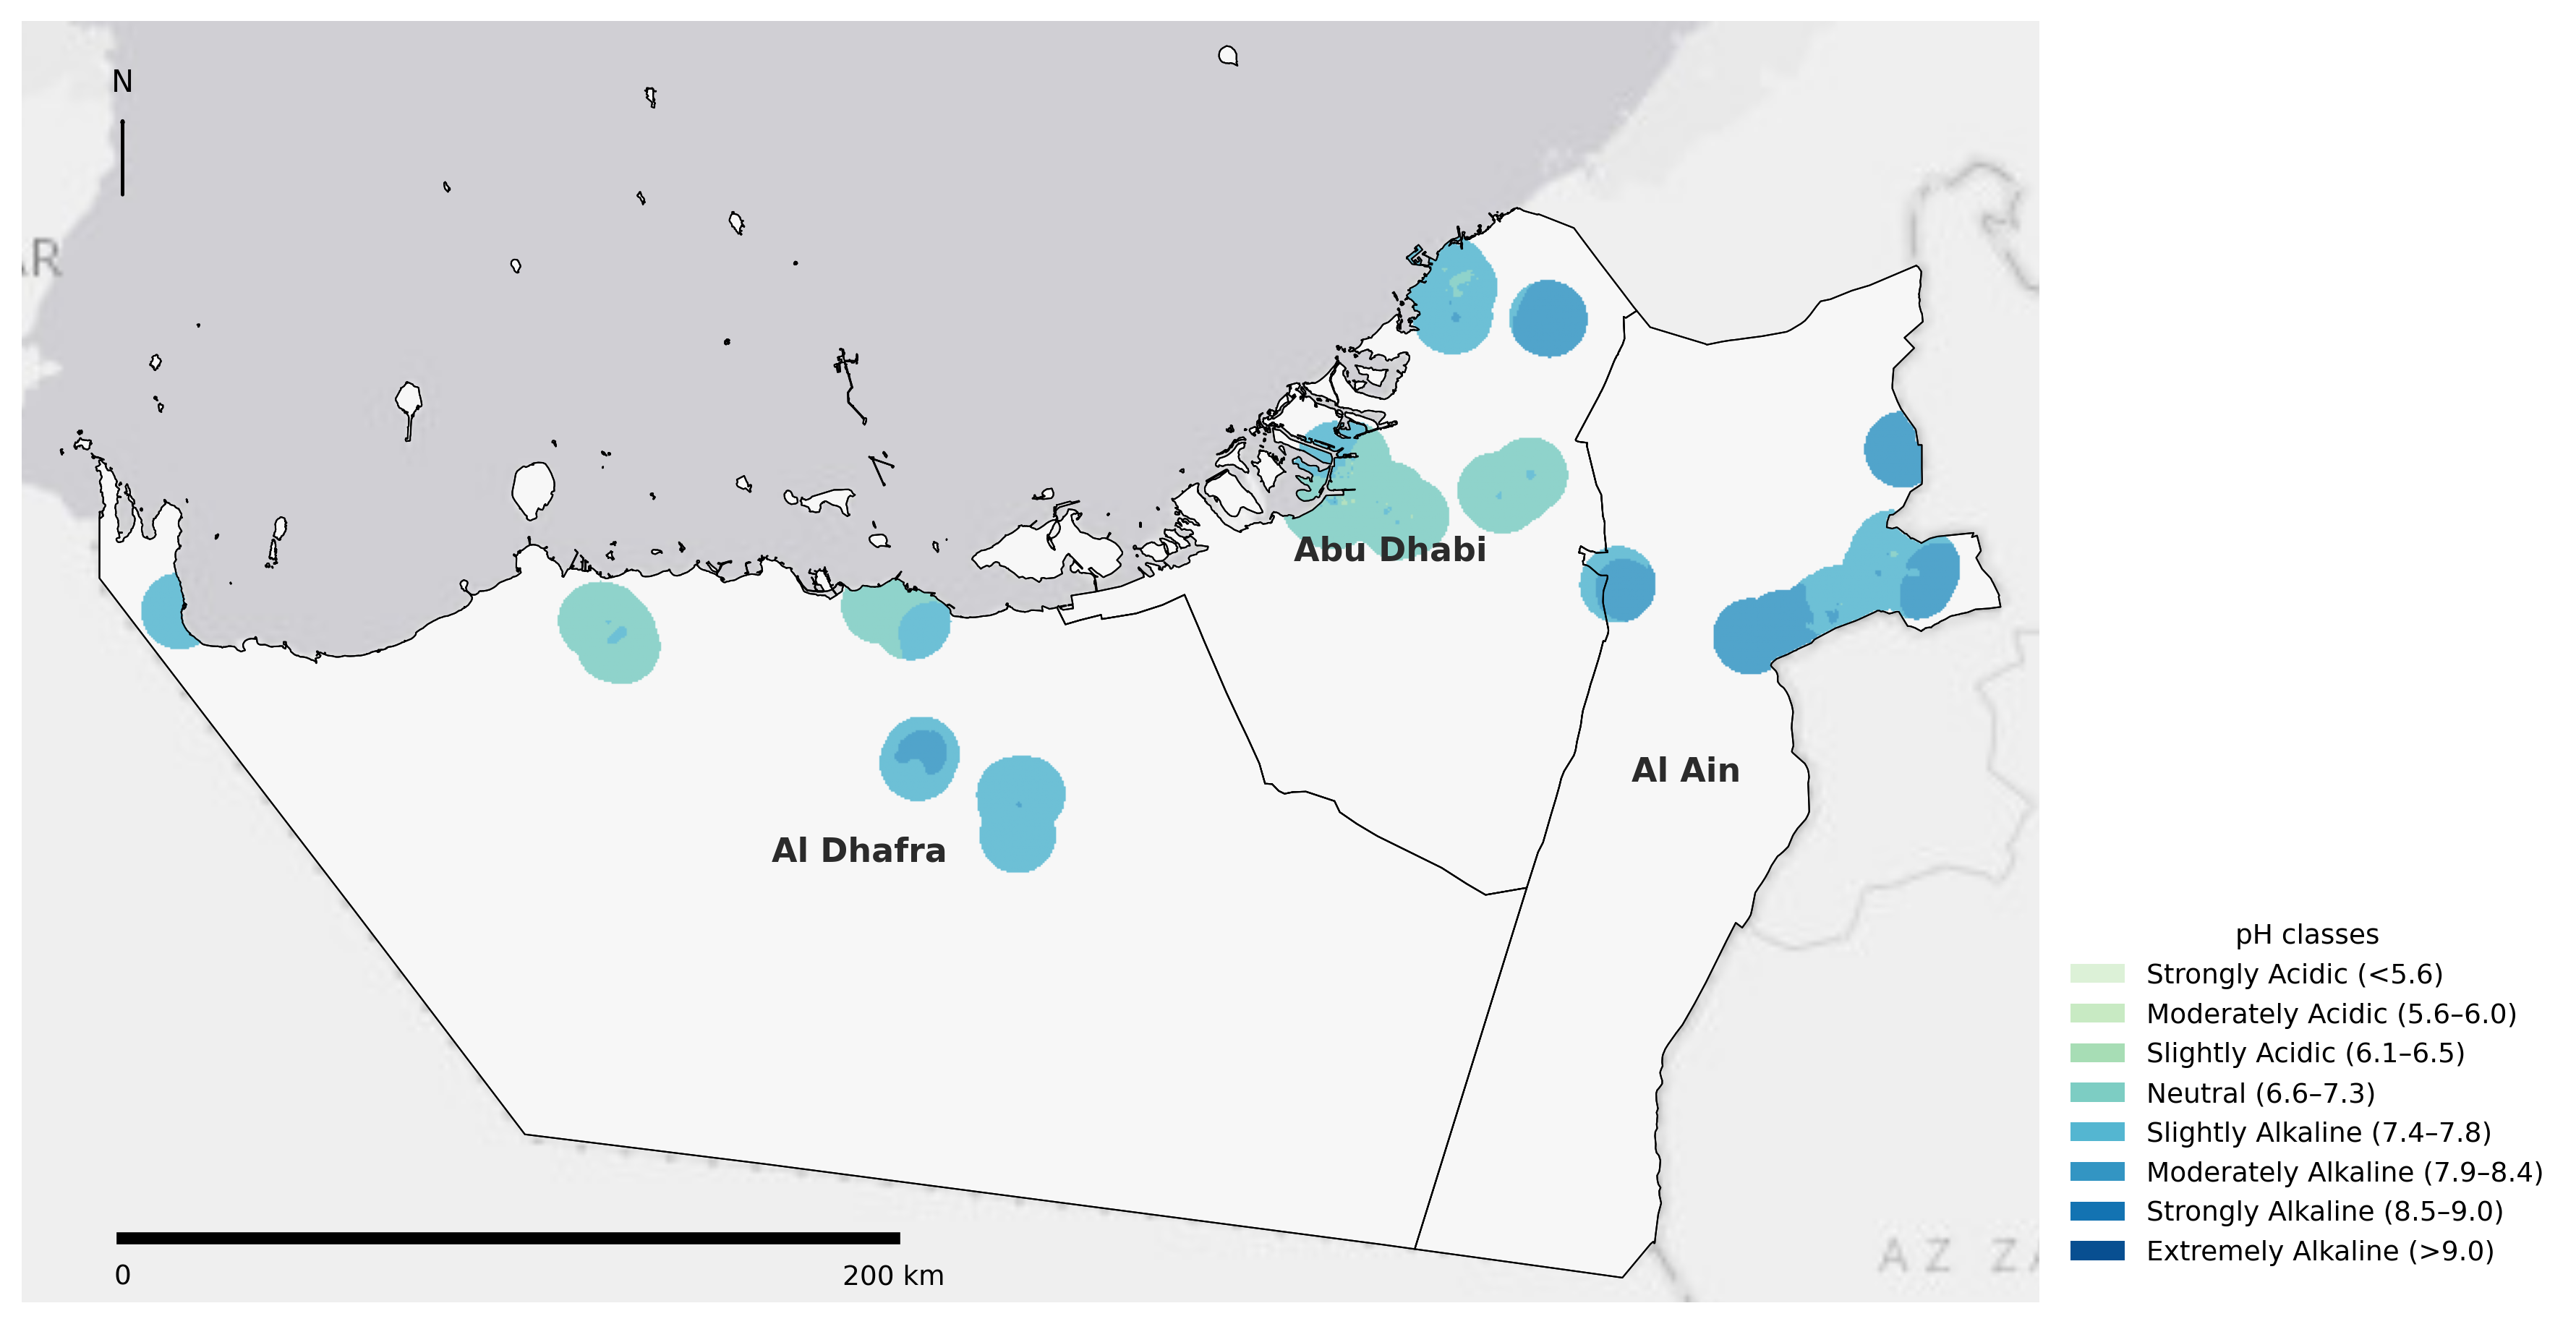

[INFO] satec valid points (within Abu Dhabi): 169
[INFO] satec min=0.623 max=253


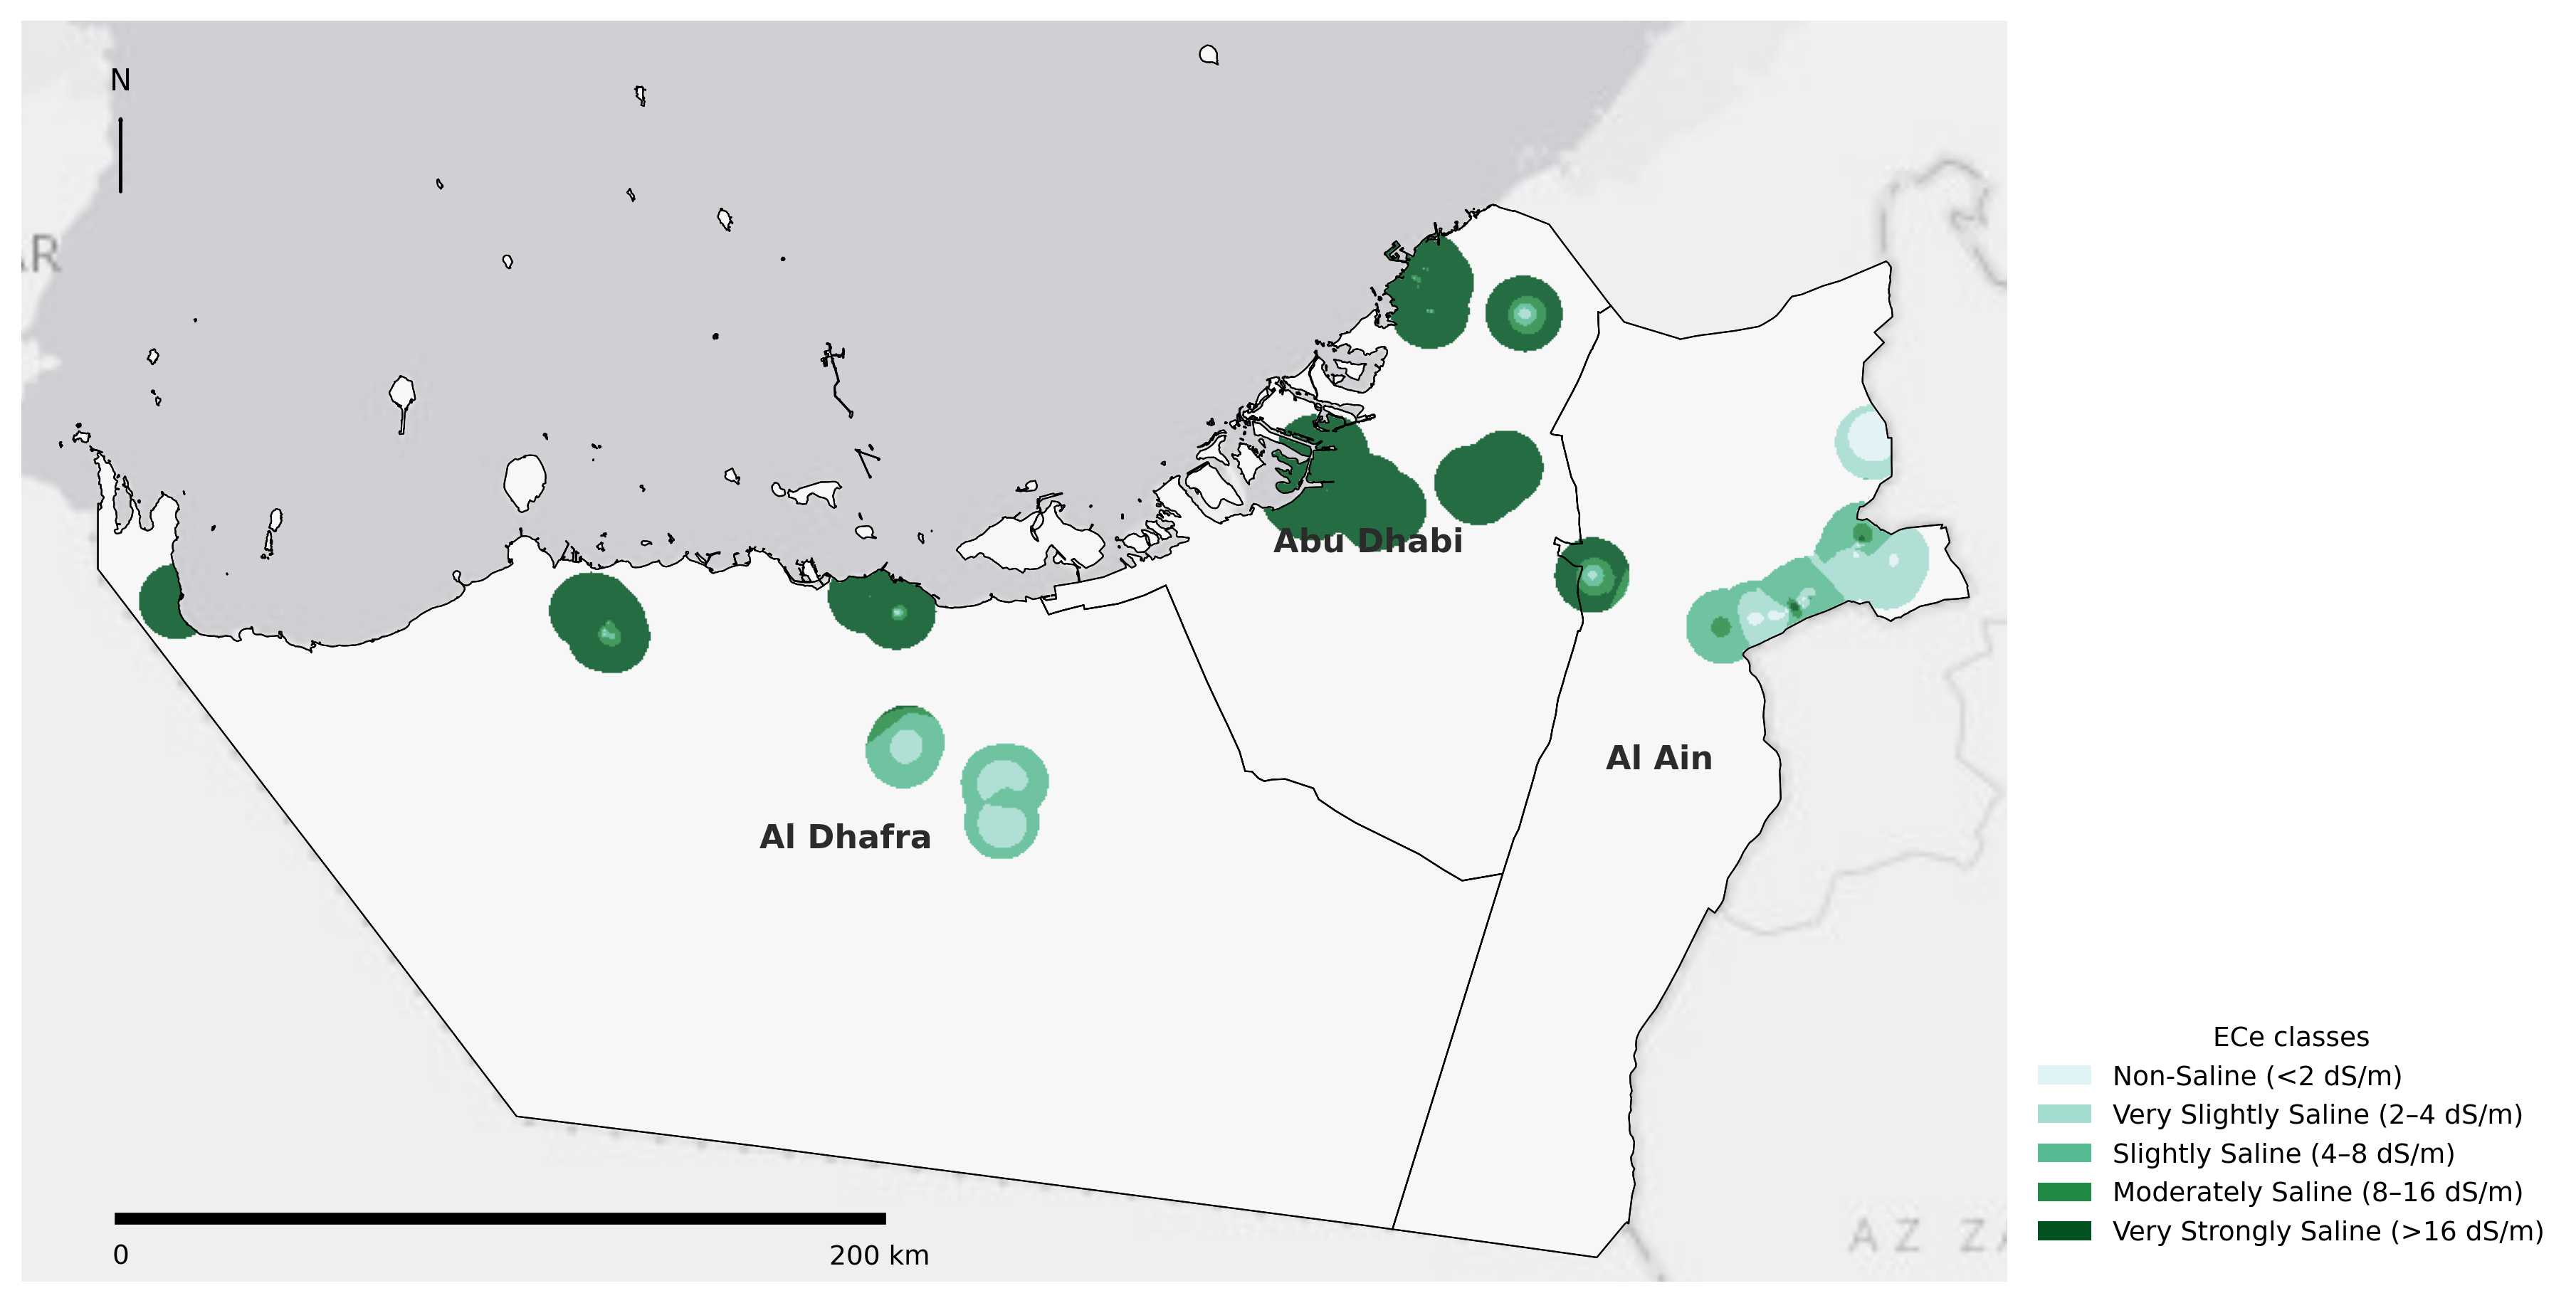

In [2]:
# ============================================================
# IDW Local Map (Binned / Classified) — Full Script
# - IDW interpolation (with optional radius limit)
# - Optional rounding of IDW surface BEFORE binning (e.g., round(1))
# - Binning rules exactly like your Ch06 style (bins = [(lo, hi, label), ...])
# - Discrete colors sampled from a cmap (ListedColormap)
# - Legend via Patch handles (same style as Ch06; no continuous colorbar)
# - Mask outside Abu Dhabi boundary
# - Basemap safe wrapper
# - Optional protected areas overlay
# - Optional region labels (Al Dhafra / Abu Dhabi / Al Ain) placed inside polygons
# ============================================================

import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import matplotlib as mpl
import matplotlib.colors as mcolors

from matplotlib.patches import FancyArrowPatch, Patch
from shapely.ops import unary_union
from scipy.spatial import cKDTree
from shapely import points as shapely_points

mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["savefig.dpi"] = 300


# ============================================================
# Map decorations
# ============================================================
def add_north_arrow(ax, x=0.05, y=0.86, dy=0.07):
    arrow = FancyArrowPatch(
        (x, y), (x, y + dy),
        transform=ax.transAxes,
        arrowstyle="-|>",
        linewidth=1.2,
        color="black",
        zorder=30,
    )
    ax.add_patch(arrow)
    ax.text(
        x, y + dy + 0.01, "N",
        transform=ax.transAxes,
        ha="center", va="bottom",
        fontsize=10, zorder=30,
    )


def add_scale_bar(ax, xmin, ymin, xmax, ymax, length_km=200):
    length_m = length_km * 1000
    x0 = xmin + 0.05 * (xmax - xmin)
    y0 = ymin + 0.05 * (ymax - ymin)

    ax.plot([x0, x0 + length_m], [y0, y0],
            color="black", linewidth=4, zorder=30)

    ax.text(x0, y0 - 0.02 * (ymax - ymin), "0",
            ha="center", va="top", fontsize=9)

    ax.text(x0 + length_m, y0 - 0.02 * (ymax - ymin),
            f"{length_km} km",
            ha="center", va="top", fontsize=9)


# ============================================================
# Basemap safe wrapper
# ============================================================
def add_basemap_safe(ax, *, source, zoom, attribution=False):
    try:
        cx.add_basemap(ax, source=source, zoom=zoom, attribution=attribution)
        return True
    except Exception as e:
        print(f"[WARN] Basemap failed, continue without basemap. {type(e).__name__}: {e}")
        return False


# ============================================================
# Discrete bin classification for raster (with optional rounding)
# ============================================================
def classify_raster_by_bins(
    grid_z_masked: np.ma.MaskedArray,
    bins: list[tuple[float, float, str]],
    *,
    cmap_name: str = "GnBu",
    sample_range=(0.15, 0.95),
    gap_color: str = "#9e9e9e",
    nan_color: str = "#ffffff00",   # transparent for masked
    inclusive: str = "right",       # "right": (lo, hi] ; "both": [lo, hi]
    round_decimals: int | None = None,
):
    """
    Convert continuous raster -> discrete class raster based on bins.

    Parameters
    ----------
    grid_z_masked : np.ma.MaskedArray
        IDW surface with mask outside boundary.
    bins : list[(lo, hi, label)]
        Classification bins. Supports gaps.
    cmap_name : str
        Matplotlib colormap name to sample discrete colors from.
    inclusive : "right" or "both"
        "right": (lo, hi]  (recommended; avoids overlaps at boundaries)
        "both": [lo, hi]   (use if you want your pH logic exactly)
    round_decimals : int | None
        If not None, round IDW surface BEFORE binning (e.g., 1) to mimic point rounding.

    Returns
    -------
    class_for_plot : np.ma.MaskedArray
        Values are 0 for GAP, 1..n for bins[0..n-1]; masked stays masked.
    cmap_discrete : ListedColormap
    norm : BoundaryNorm
    legend_handles : list[Patch]
    label2color : dict[label -> hex]
    """
    z = grid_z_masked.data.astype(float).copy()
    mask = np.array(grid_z_masked.mask, dtype=bool)

    # Treat NaN/inf as masked (e.g., radius NaN)
    mask |= ~np.isfinite(z)

    # Optional rounding of IDW surface (key request)
    if round_decimals is not None:
        z = np.round(z, round_decimals)

    n = len(bins)
    class_idx = np.full(z.shape, fill_value=-1, dtype=np.int32)

    valid = ~mask
    zv = z[valid]

    for i, (lo, hi, _lab) in enumerate(bins):
        if inclusive == "both":
            hit = (zv >= lo) & (zv <= hi)
        else:
            hit = (zv > lo) & (zv <= hi)  # (lo, hi]
        # assign only where hit; otherwise keep previous
        tmp = class_idx[valid]
        tmp = np.where(hit, i, tmp)
        class_idx[valid] = tmp

    labels = [b[2] for b in bins]
    cmap = mpl.colormaps.get(cmap_name)
    sample_pos = np.linspace(sample_range[0], sample_range[1], n)
    colors = [mcolors.to_hex(cmap(p)) for p in sample_pos]
    label2color = dict(zip(labels, colors))

    # Build ListedColormap: index 0 = GAP, 1..n = bins
    cmap_list = [gap_color] + colors
    cmap_discrete = mcolors.ListedColormap(cmap_list)
    cmap_discrete.set_bad(nan_color)

    # For plotting: GAP -> 0, bin i -> i+1
    class_for_plot = class_idx.copy()
    class_for_plot[class_for_plot >= 0] += 1
    class_for_plot = np.ma.array(class_for_plot, mask=mask)

    # Boundaries: [-0.5,0.5]=GAP; [0.5,1.5]=bin0 ... [n-0.5,n+0.5]=bin(n-1)
    boundaries = np.arange(-0.5, (n + 1) + 0.5, 1.0)
    norm = mcolors.BoundaryNorm(boundaries=boundaries, ncolors=len(cmap_list))

    legend_handles = [
        Patch(facecolor=label2color[lab], edgecolor="none", label=lab)
        for lab in labels
    ]

    return class_for_plot, cmap_discrete, norm, legend_handles, label2color


# ============================================================
# IDW interpolation map function (Binned)
# ============================================================
def plot_idw_local_map_binned(
    *,
    excel_path: str,
    sheet_name: str,
    value_col: str,
    element_name: str,
    abu_dhabi_shp: str,
    out_png: str | None = None,

    # Optional filtering
    survey_id: int | None = None,
    survey_col: str = "SurveyID",

    # IDW params
    power: float = 2.0,
    k: int = 12,
    eps: float = 1e-12,
    radius: float | None = 10_000,   # meters; None -> no radius limit

    # grid params
    grid_res: int = 500,

    # classification params (Ch06 style)
    bins: list[tuple[float, float, str]] | None = None,
    bins_cmap_name: str = "GnBu",
    bins_inclusive: str = "right",      # "right" or "both"
    bins_round_decimals: int | None = 1,  # <= THIS answers your question: round(1) before binning
    gap_color: str = "#9e9e9e",

    # basemap
    basemap=cx.providers.Esri.WorldGrayCanvas,
    basemap_zoom: int = 7,
    basemap_attribution: bool = False,

    # polygons styling
    region_facecolor: str = "#f7f7f7",
    region_edgecolor: str = "black",
    region_linewidth: float = 0.5,
    boundary_linewidth: float = 0.5,

    # optional protected areas overlay
    protected_gpkg: str | None = None,
    protected_layer: str | None = None,
    protected_facecolor: str = "#7FD3C3",
    protected_alpha: float = 0.45,

    # extent padding
    pad_ratio: float = 0.02,

    # decorations
    scale_km: int = 200,
    figsize=(12, 8),

    # legend placement (match your Ch06)
    legend_outside: bool = True,
    legend_fontsize: int = 9,

    # optional region labels (like your earlier function)
    add_region_labels: bool = True,
):
    if bins is None:
        raise ValueError("bins is required for binned IDW. Provide bins=[(lo,hi,label), ...].")

    # -------------------------
    # 1) boundaries -> one polygon
    # -------------------------
    regions = gpd.read_file(abu_dhabi_shp).to_crs(3857)
    abu_geom = unary_union(regions.geometry)

    protected = None
    if protected_gpkg and protected_layer:
        protected = gpd.read_file(protected_gpkg, layer=protected_layer).to_crs(3857)
        protected = protected[(~protected.geometry.isna()) & (~protected.geometry.is_empty)].copy()

    # -------------------------
    # 2) read points + clean
    # -------------------------
    df = pd.read_excel(excel_path, sheet_name=sheet_name)

    if (survey_id is not None) and (survey_col in df.columns):
        df = df[df[survey_col] == survey_id].copy()

    need_cols = ["Longitude", "Latitude", value_col]
    missing = [c for c in need_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in Excel: {missing}. Available: {list(df.columns)}")

    df = df.dropna(subset=need_cols).copy()
    df[value_col] = pd.to_numeric(df[value_col], errors="coerce")
    df = df.dropna(subset=[value_col]).copy()

    gdf_pts = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df["Longitude"], df["Latitude"]),
        crs="EPSG:4326",
    ).to_crs(3857)

    # keep points inside Abu Dhabi
    gdf_pts = gdf_pts[gdf_pts.geometry.within(abu_geom)].copy()

    xy = np.column_stack([gdf_pts.geometry.x.values, gdf_pts.geometry.y.values])
    vals = gdf_pts[value_col].values.astype(float)

    print(f"[INFO] {value_col} valid points (within Abu Dhabi): {xy.shape[0]}")
    if xy.shape[0] < 3:
        raise ValueError(f"Not enough valid points for IDW. Got {xy.shape[0]} points.")
    print(f"[INFO] {value_col} min={np.nanmin(vals):.4g} max={np.nanmax(vals):.4g}")

    # -------------------------
    # 3) grid
    # -------------------------
    xmin, ymin, xmax, ymax = regions.total_bounds
    xpad = pad_ratio * (xmax - xmin)
    ypad = pad_ratio * (ymax - ymin)
    xmin2, xmax2 = xmin - xpad, xmax + xpad
    ymin2, ymax2 = ymin - ypad, ymax + ypad

    xs = np.arange(xmin2, xmax2 + grid_res, grid_res)
    ys = np.arange(ymin2, ymax2 + grid_res, grid_res)
    grid_x, grid_y = np.meshgrid(xs, ys)
    grid_points = np.column_stack([grid_x.ravel(), grid_y.ravel()])

    # -------------------------
    # 4) IDW (kNN)
    # -------------------------
    tree = cKDTree(xy)
    k_use = min(k, xy.shape[0])

    dists, idxs = tree.query(grid_points, k=k_use)
    if k_use == 1:
        dists = dists[:, None]
        idxs = idxs[:, None]

    weights = 1.0 / (np.power(dists, power) + eps)
    z = np.sum(weights * vals[idxs], axis=1) / np.sum(weights, axis=1)

    # Optional radius limit: if no neighbor within radius -> NaN
    if radius is not None:
        within = (dists <= radius)
        z[~within.any(axis=1)] = np.nan

    grid_z = z.reshape(grid_x.shape)

    # -------------------------
    # 5) mask outside Abu Dhabi
    # -------------------------
    mask_points = shapely_points(grid_x.ravel(), grid_y.ravel())
    inside = np.array([abu_geom.contains(p) for p in mask_points], dtype=bool)
    mask_outside = ~inside.reshape(grid_x.shape)

    # masked array (outside boundary masked)
    grid_z_masked = np.ma.array(grid_z, mask=mask_outside)

    # -------------------------
    # 6) classify raster (optionally round BEFORE binning)
    # -------------------------
    class_grid, cmap_discrete, norm, legend_handles, _ = classify_raster_by_bins(
        grid_z_masked,
        bins=bins,
        cmap_name=bins_cmap_name,
        gap_color=gap_color,
        inclusive=bins_inclusive,
        round_decimals=bins_round_decimals,   # <<<<<< round(1) here if set to 1
    )

    # -------------------------
    # 7) plot (background style = your reference)
    # -------------------------
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(xmin2, xmax2)
    ax.set_ylim(ymin2, ymax2)

    add_basemap_safe(ax, source=basemap, zoom=basemap_zoom, attribution=basemap_attribution)

    regions.plot(
        ax=ax,
        facecolor=region_facecolor,
        edgecolor=region_edgecolor,
        linewidth=region_linewidth,
        zorder=4,
    )

    if protected is not None:
        protected.plot(
            ax=ax,
            facecolor=protected_facecolor,
            edgecolor="none",
            alpha=protected_alpha,
            zorder=4.5,
        )

    im = ax.imshow(
        class_grid,
        extent=(xs.min(), xs.max(), ys.min(), ys.max()),
        origin="lower",
        cmap=cmap_discrete,
        norm=norm,
        alpha=0.85,
        zorder=5,
    )

    regions.boundary.plot(ax=ax, color="black", linewidth=boundary_linewidth, zorder=10)

    # Optional region labels (3 main regions)
    if add_region_labels:
        candidate_fields = ["NAMEENGLISH", "NameEnglish", "NAME", "Name", "Region", "REGION", "emirate", "EMIRATE"]
        name_field = next((f for f in candidate_fields if f in regions.columns), None)
        if name_field is not None:
            region_keywords = [
                ("Al Dhafra", ["Dhafra"]),
                ("Abu Dhabi", ["Abu Dhabi"]),
                ("Al Ain", ["Ain"]),
            ]
            for label, keys in region_keywords:
                m = np.zeros(len(regions), dtype=bool)
                for kk in keys:
                    m |= regions[name_field].astype(str).str.contains(kk, case=False, na=False)
                reg = regions[m].copy()
                if len(reg) == 0:
                    continue
                reg_one = reg.dissolve()
                rp = reg_one.geometry.iloc[0].representative_point()
                ax.text(
                    rp.x, rp.y, label,
                    ha="center", va="center",
                    fontsize=11,
                    color="#2b2b2b",
                    fontweight="bold",
                    zorder=25,
                )

    add_north_arrow(ax)
    add_scale_bar(ax, xmin2, ymin2, xmax2, ymax2, length_km=scale_km)

    # Legend (Ch06 style)
    title = f"{element_name} classes"
    if legend_outside:
        ax.legend(
            handles=legend_handles,
            title=title,
            loc="lower left",
            bbox_to_anchor=(1.01, 0.02),
            frameon=False,
            fontsize=legend_fontsize,
            title_fontsize=legend_fontsize,
            ncol=1,
            borderaxespad=0.0,
        )
    else:
        ax.legend(
            handles=legend_handles,
            title=title,
            loc="lower left",
            frameon=False,
            fontsize=legend_fontsize,
            title_fontsize=legend_fontsize,
        )

    ax.set_axis_off()

    if out_png:
        os.makedirs(os.path.dirname(out_png), exist_ok=True)
        fig.savefig(out_png, dpi=300, bbox_inches="tight")
        print("[INFO] Saved:", out_png)

    plt.show()
    return fig, ax


# ============================================================
# Example usage (pH + ECe)
# ============================================================
OUT_DIR = r"../Result_hmq/Ch07_Figures"
os.makedirs(OUT_DIR, exist_ok=True)

EXCEL = r"../Result_hmq/Soil quality data QC/Soil quality data QC 2025.xlsx"
SHEET = "Processed_Data"
SHP = r"../data_hmq/Map/abu_dhabi.shp"

# --- pH bins (your Ch06)
ph_bins = [
    (-float("inf"), 5.6,  "Strongly Acidic (<5.6)"),
    (5.6, 6.1,       "Moderately Acidic (5.6–6.0)"),
    (6.1, 6.6,       "Slightly Acidic (6.1–6.5)"),
    (6.6, 7.4,       "Neutral (6.6–7.3)"),
    (7.4, 7.9,       "Slightly Alkaline (7.4–7.8)"),
    (7.9, 8.5,       "Moderately Alkaline (7.9–8.4)"),
    (8.5, 9.0,       "Strongly Alkaline (8.5–9.0)"),
    (9.0, float("inf"), "Extremely Alkaline (>9.0)"),
]

# --- ECe bins (your Ch06)
ece_bins = [
    (-float("inf"), 2.0,           "Non-Saline (<2 dS/m)"),
    (2.0, 4.0,                    "Very Slightly Saline (2–4 dS/m)"),
    (4.0, 8.0,                    "Slightly Saline (4–8 dS/m)"),
    (8.0, 16.0,                   "Moderately Saline (8–16 dS/m)"),
    (16.0, float("inf"),          "Very Strongly Saline (>16 dS/m)"),
]

# If you want one land-use only:
SURVEY_ID = 9  # set None for all

# pH IDW binned map (ROUND(1) BEFORE BINNING — enabled by bins_round_decimals=1)
fig, ax = plot_idw_local_map_binned(
    excel_path=EXCEL,
    sheet_name=SHEET,
    value_col="satph",
    element_name="pH",
    abu_dhabi_shp=SHP,
    survey_id=SURVEY_ID,
    grid_res=500,
    radius=10_000,
    bins=ph_bins,
    bins_cmap_name="GnBu",
    bins_inclusive="right",       # (lo, hi]
    bins_round_decimals=1,        # <<<<<< key: round(1) before binning
    basemap=cx.providers.Esri.WorldGrayCanvas,
    basemap_zoom=7,
    legend_outside=True,
)
fig.savefig(os.path.join(OUT_DIR, "Ch07_pH_IDW_binned.png"), bbox_inches="tight", pad_inches=0.1)
fig.savefig(os.path.join(OUT_DIR, "Ch07_pH_IDW_binned.svg"), bbox_inches="tight", pad_inches=0.1)

# ECe IDW binned map
fig, ax = plot_idw_local_map_binned(
    excel_path=EXCEL,
    sheet_name=SHEET,
    value_col="satec",
    element_name="ECe",
    abu_dhabi_shp=SHP,
    survey_id=SURVEY_ID,
    grid_res=500,
    radius=10_000,
    bins=ece_bins,
    bins_cmap_name="BuGn",
    bins_inclusive="right",
    bins_round_decimals=1,        # same rounding logic
    basemap=cx.providers.Esri.WorldGrayCanvas,
    basemap_zoom=7,
    legend_outside=True,
)
fig.savefig(os.path.join(OUT_DIR, "Ch07_ECe_IDW_binned.png"), bbox_inches="tight", pad_inches=0.1)
fig.savefig(os.path.join(OUT_DIR, "Ch07_ECe_IDW_binned.svg"), bbox_inches="tight", pad_inches=0.1)
